# 6 Object Detection
- Template matching
- Corner detection
- Edge Detection
- Grid detection
- Contour detection
- Feature matching: most advanced method
- Watershed
- Facial and eye detection with Haar cascades
- Project: blurring license plates

## 6.7 Watershed Segmentation

Watershed = Drainage Divide = Geographical area that channels rainfall and water. These watershed areas are then topographically segmented.

Images are treated as topography: brightness is height; high values are peaks, low values valleys.

Image is filled with "water" in the images and segments appear, which are delimited with boundaries. As the "water" increases, if no boundaries set, everything would merge.

Typical use cases:
- Coins touching each other on image: segment them
- Foreground-background segmentation
- Segment elements in the scene, even in 3D space

We can manually set the **seeds** to influence the segmentation.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

In [3]:
sep_coins = cv2.imread('../../data/pennies.jpg')

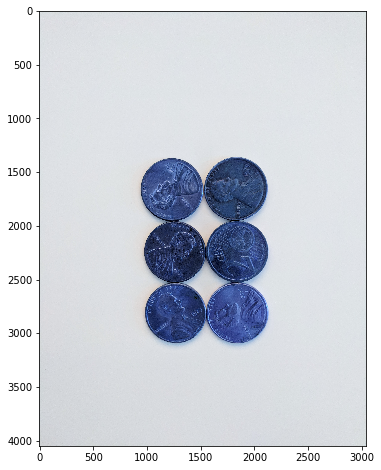

In [5]:
# For the human eye it's easy to distinguish each coin
# But for the computer, it's difficult to find the coin boundaries
display(sep_coins)

In [6]:
# Median blur
# Grayscale
# Binary threshold
# Find contours

In [8]:
sep_coins = cv2.medianBlur(sep_coins,25)

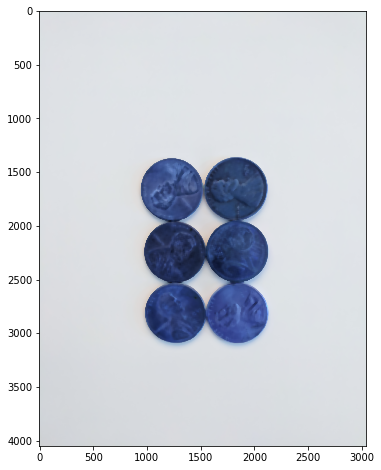

In [9]:
display(sep_coins)

In [10]:
sep_coins = cv2.cvtColor(sep_coins, cv2.COLOR_BGR2GRAY)

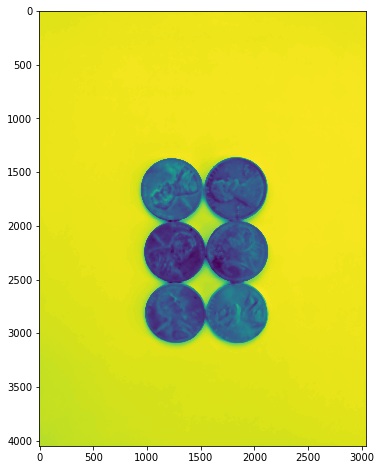

In [11]:
display(sep_coins)

In [20]:
ret, sep_thres = cv2.threshold(sep_coins, 160, 255, cv2.THRESH_BINARY_INV)

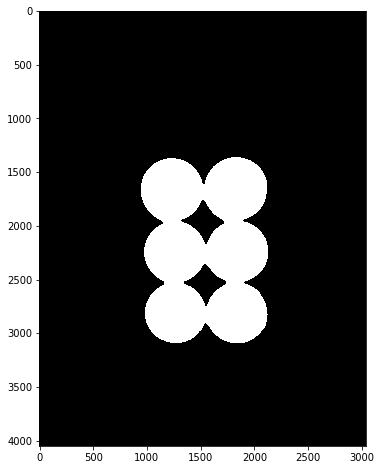

In [21]:
display(sep_thres,cmap='gray')